In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/Volumes/GoogleDrive/My Drive/BEAM-CORE/BEAM Validation')

plt.style.use('ggplot')

In [4]:
# load data for validation
modeled_vmt = read_csv('sample output/AUS2018/0.linkstats.csv.gz', low_memory=False)
observed_vmt = read_csv('data for validation/Austin/VMT/austin_roadway_inventory.csv', low_memory=False)
model_network = read_csv('sample output/AUS2018/beam_network_by_county.csv', low_memory=False)
modeled_vmt.head(5)

,link,from,to,hour,length,freespeed,capacity,stat,volume,traveltime
0,285550,102109,120927,0.0,13.623,14.75232,2100.0,AVG,0.0,0.923448
1,285550,102109,120927,1.0,13.623,14.75232,2100.0,AVG,0.0,0.923448
2,285550,102109,120927,2.0,13.623,14.75232,2100.0,AVG,0.0,0.923448
3,285550,102109,120927,3.0,13.623,14.75232,2100.0,AVG,0.0,0.923448
4,285550,102109,120927,4.0,13.623,14.75232,2100.0,AVG,0.0,0.923448


In [30]:
observed_vmt.head(5)
total_lane_mile_observed = observed_vmt['LN_MILES'].sum()
print(total_lane_mile_observed)

31169.408


In [32]:
meter_to_mile = 0.000621371
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)
model_network.loc[:, 'lane_mile'] = meter_to_mile * model_network.loc[:, 'linkLength'] * model_network.loc[:, 'numberOfLanes']
total_lane_mile_modeled = model_network['lane_mile'].sum()
print(total_lane_mile_modeled)

46312.51890791604


In [22]:
# filter modeled network
# model_vmt_24_hour = modeled_vmt.loc[modeled_vmt['hour'] <= 23]
model_network['fromNodeId'] = model_network['fromNodeId'].astype(int)
model_network['toNodeId'] = model_network['toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(modeled_vmt, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'left')
model_vmt_24_hour.head(5)

,link,from,to,hour,length_x,freespeed,capacity,stat,volume,traveltime,...,linkCapacity,numberOfLanes,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,name,txdot_abbr,fips_code
0,285550,102109,120927,0.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,2100.0,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0
1,285550,102109,120927,1.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,2100.0,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0
2,285550,102109,120927,2.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,2100.0,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0
3,285550,102109,120927,3.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,2100.0,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0
4,285550,102109,120927,4.0,13.623,14.75232,2100.0,AVG,0.0,0.923448,...,2100.0,1.0,car;walk;bike,544896591.0,tertiary,102109.0,120927.0,Williamson,14.0,491.0


In [39]:
model_vmt_24_hour.loc[:, 'lane_mile'] = meter_to_mile * model_vmt_24_hour.loc[:, 'numberOfLanes'] * model_vmt_24_hour.loc[:, 'linkLength'] / 60.0
total_lane_mile_with_cars = model_vmt_24_hour.loc[:, 'lane_mile'].sum()
print(total_lane_mile_with_cars)

46312.518907916


In [23]:
model_vmt_24_hour = model_vmt_24_hour.rename(columns = {'length_x': 'length_raw', 
                                                        'length_y': 'length_adj'})
print(model_vmt_24_hour.columns)

Index(['link', 'from', 'to', 'hour', 'length_raw', 'freespeed', 'capacity',
       'stat', 'volume', 'traveltime', 'Unnamed: 0', 'linkId', 'linkLength',
       'length_adj', 'linkFreeSpeed', 'linkCapacity', 'numberOfLanes',
       'linkModes', 'attributeOrigId', 'attributeOrigType', 'fromNodeId',
       'toNodeId', 'name', 'txdot_abbr', 'fips_code'],
      dtype='object')


In [33]:
percent_of_samples = 0.2
demand_scaling = 1/percent_of_samples
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
model_vmt_by_county = model_vmt_24_hour.groupby(['name'])[['VMT']].sum()
model_vmt_by_county = model_vmt_by_county.reset_index()
model_vmt_by_county


,name,VMT
0,Bastrop,1.945346e+06
1,Burnet,2.234923e+06
2,Caldwell,9.657520e+05
3,Hays,3.399911e+06
4,Travis,2.526090e+07
5,Williamson,8.731701e+06


['car;walk;bike' 'walk;bike' 'car;bike' 'bike' nan]


In [36]:
observed_vmt.loc[:, 'PVMT'] = observed_vmt.loc[:, 'DVMT'] - observed_vmt.loc[:, 'DTRKVMT']
observed_vmt_by_county = observed_vmt.groupby('County.Name')[['PVMT']].sum()
observed_vmt_by_county = observed_vmt_by_county.reset_index()
observed_vmt_by_county

,County.Name,PVMT
0,Bastrop,4.794145e+06
1,Burnet,1.755911e+06
2,Caldwell,1.827492e+06
3,Hays,1.071075e+07
4,Travis,5.805417e+07
5,Williamson,2.173452e+07


In [37]:
VMT_comparison = pd.merge(model_vmt_by_county, observed_vmt_by_county, 
                          left_on = 'name', right_on = 'County.Name', how = 'left')
VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison.columns = ['county', 'modeled_VMT', 'observed_VMT']
VMT_comparison

,county,modeled_VMT,observed_VMT
0,Bastrop,1.945346e+06,4.794145e+06
1,Burnet,2.234923e+06,1.755911e+06
2,Caldwell,9.657520e+05,1.827492e+06
3,Hays,3.399911e+06,1.071075e+07
4,Travis,2.526090e+07,5.805417e+07
5,Williamson,8.731701e+06,2.173452e+07


Text(0.5, 1.0, 'VMT comparison')

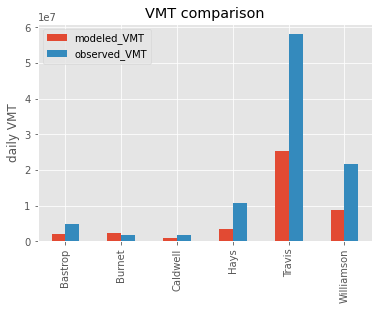

In [38]:
VMT_comparison.plot.bar(x = 'county')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison')